# Goal: 
Company XYZ is an e-commerce site that sells hand-made clothes.
You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").
* These are the tasks you are asked to do:
1. For each user, determine her country based on the numeric IP address.
2. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
3. Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
4. Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

## Data Explore

In [21]:
import numpy as np
import pandas as pd
#visu
import matplotlib.pyplot as plt
import seaborn as sns


In [38]:
fraud = pd.read_csv('Fraud_Data.csv', parse_dates = ['signup_time', 'purchase_time'])
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [74]:
fraud.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
deviceNum         0
ipNum             0
signUpDay         0
signUpWeek        0
purchaseDay       0
purchaseWeek      0
timeDiff          0
dtype: int64

In [23]:
ip = pd.read_csv('IpAddress_to_Country.csv')
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Task one: determine her country based on the numeric IP address.

In [40]:
#wrong
fraud['country'] = [ip['country'] for fraud[i,'ip_address'] in range(lambda x: ip['lower_bound_ip_address'] =< x  and x <= ip['upper_bound_ip_address']

SyntaxError: invalid syntax (<ipython-input-40-2c5eab7b4aee>, line 2)

In [41]:
countries = []
for i in range(len(fraud)):
    ip_address = fraud.loc[i,'ip_address']# row with index
    tmp = ip[(ip['lower_bound_ip_address'] <= ip_address) &
                          (ip['upper_bound_ip_address'] >= ip_address)] #use ip_address loop ip table
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])# only keep the country name
    else:
        countries.append('Na')
        
fraud['country'] = countries


In [42]:
fraud['country'].head()

0            Japan
1    United States
2    United States
3               Na
4    United States
Name: country, dtype: object

## Feature Engineering

* Time difference between sign-up time and purchase time
* If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
* Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
* Usual week of the year and day of the week from time variables

In [52]:
# The duration time between purchase and signup
timeDiff = fraud['purchase_time'] - fraud['signup_time']
timeDiff = timeDiff.apply(lambda x: x.seconds)
fraud['timeDiff'] = timeDiff

In [49]:
# Number of userId for unique devices
deviceNum = fraud[['user_id','device_id']].groupby('device_id').count().reset_index()
deviceNum = deviceNum.rename(columns = {'user_id':'deviceNum'})
fraud = fraud.merge(deviceNum, how = 'left', on = 'device_id')
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,deviceNum
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Na,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1


In [50]:
# check user number for unique ip_address
ipNum = fraud[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ipNum = ipNum.rename(columns = {'user_id':'ipNum'})
fraud = fraud.merge(ipNum, how = 'left', on = 'ip_address')
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,deviceNum,ipNum
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Na,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1


In [51]:
# Usual day of week, week of year to signup
fraud['signUpDay'] = fraud['signup_time'].apply(lambda x: x.dayofweek)
fraud['signUpWeek'] = fraud['signup_time'].apply(lambda x: x.week)

# Usual day of week, week of year to purchase
fraud['purchaseDay'] = fraud['purchase_time'].apply(lambda x: x.dayofweek)
fraud['purchaseWeek'] = fraud['purchase_time'].apply(lambda x: x.week)

## Fraudulent Activity Identification
Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
    

In [45]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [46]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_271"; Java(TM) SE Runtime Environment (build 1.8.0_271-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from /Users/qq/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/mf/dvy3p8pn1_l5vrt3c8b5sr8w0000gn/T/tmpzell7mh5
  JVM stdout: /var/folders/mf/dvy3p8pn1_l5vrt3c8b5sr8w0000gn/T/tmpzell7mh5/h2o_qq_started_from_python.out
  JVM stderr: /var/folders/mf/dvy3p8pn1_l5vrt3c8b5sr8w0000gn/T/tmpzell7mh5/h2o_qq_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_qq_0ca7vl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [53]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,deviceNum,ipNum,signUpDay,signUpWeek,purchaseDay,purchaseWeek,timeDiff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1,9,5,16,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,6,23,0,24,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,3,1,3,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Na,1,1,1,18,0,19,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1,30,2,37,41461


In [54]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(fraud)

for name in ['signUpDay', 'purchaseDay', 'source', 'browser', 'sex', 'country', 'class']:
    h2o_df[name] = h2o_df[name].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,deviceNum,ipNum,signUpDay,signUpWeek,purchaseDay,purchaseWeek,timeDiff
type,int,time,time,int,string,enum,enum,enum,int,real,enum,enum,int,int,enum,int,enum,int,int
mins,2.0,1420070442000.0,1420070444000.0,9.0,NaN,,,,18.0,52093.4968949854,,,1.0,1.0,,1.0,,1.0,1.0
mean,200171.0409696117,1429491369511.3267,1434423398759.953,36.93537243898571,NaN,,,,33.14070358409659,2152145330.9588203,,,1.6843665625496305,1.60271851342051,,16.501740430938636,,24.65857112605219,40942.584427444686
maxs,400000.0,1439872829000.0,1450234565000.0,154.0,NaN,,,,76.0,4294850499.67884,,,20.0,20.0,,34.0,,51.0,86399.0
sigma,115369.28502413449,5930618906.3248625,7042565812.476398,18.32276214866213,NaN,,,,8.61773349096147,1248497030.100427,,,2.6169536028041724,2.5962395273758387,,9.814287461798862,,11.651556782719464,26049.66190211835
zeros,0,0,0,0,0,,,,0,0,,,0,0,,0,,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,22058.0,2015-02-24 22:55:49,2015-04-18 02:47:11,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,732758368.79972,0,Japan,1.0,1.0,1,9.0,5,16.0,13882.0
1,333320.0,2015-06-07 20:39:50,2015-06-08 01:38:54,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,350311387.865908,0,United States,1.0,1.0,6,23.0,0,24.0,17944.0
2,1359.0,2015-01-01 18:52:44,2015-01-01 18:52:45,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2621473820.11095,1,United States,12.0,12.0,3,1.0,3,1.0,1.0


In [55]:
# Split into 70% training and 30% test dataset
strat_split = h2o_df['class'].stratified_split(test_frac=0.3, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

# Define features and target
feature = ['signUpDay', 'signUpWeek', 'purchaseDay', 'purchaseWeek', 'purchase_value', 
           'source', 'browser', 'sex', 'age', 'country', 'timeDiff', 'deviceNum', 'ipNum']
target = 'class'


In [56]:
# Build random forest model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [57]:
model.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-01-14 17:07:11,0.249 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-01-14 17:07:13,2.159 sec,1.0,0.322241,0.726971,0.961849,0.948630,1.932196,0.098083,0.256863,1.719177,0.782855,0.492656,7.438817,0.063883
2,,2021-01-14 17:07:14,3.350 sec,2.0,0.346731,0.633023,0.956034,0.950407,1.954214,0.106205,0.209145,0.532941,0.812905,0.665010,10.385945,0.045044
3,,2021-01-14 17:07:15,4.056 sec,3.0,0.340098,0.571493,0.962500,0.957445,1.961679,0.096520,0.205390,0.413730,0.818737,0.680469,10.575972,0.045486
4,,2021-01-14 17:07:15,4.370 sec,4.0,0.339540,0.526484,0.966512,0.962605,1.968556,0.090168,0.204126,0.332535,0.824668,0.687612,10.645869,0.044978
5,,2021-01-14 17:07:16,4.642 sec,5.0,0.339569,0.482132,0.970283,0.967486,1.975679,0.085777,0.203548,0.294273,0.828143,0.691609,10.664850,0.044625
6,,2021-01-14 17:07:16,5.002 sec,6.0,0.338911,0.451221,0.974429,0.971848,1.979923,0.082259,0.203235,0.270733,0.831686,0.696022,10.669608,0.044317
7,,2021-01-14 17:07:16,5.347 sec,7.0,0.336101,0.419658,0.978143,0.976149,1.984293,0.075878,0.203166,0.252932,0.832571,0.697054,10.679152,0.044206
8,,2021-01-14 17:07:17,5.711 sec,8.0,0.333886,0.394933,0.981009,0.979572,1.987850,0.070622,0.203083,0.247872,0.832118,0.697305,10.679152,0.044162
9,,2021-01-14 17:07:17,6.030 sec,9.0,0.336189,0.382049,0.982433,0.981676,1.991199,0.068072,0.203080,0.235029,0.833211,0.697965,10.679152,0.044118


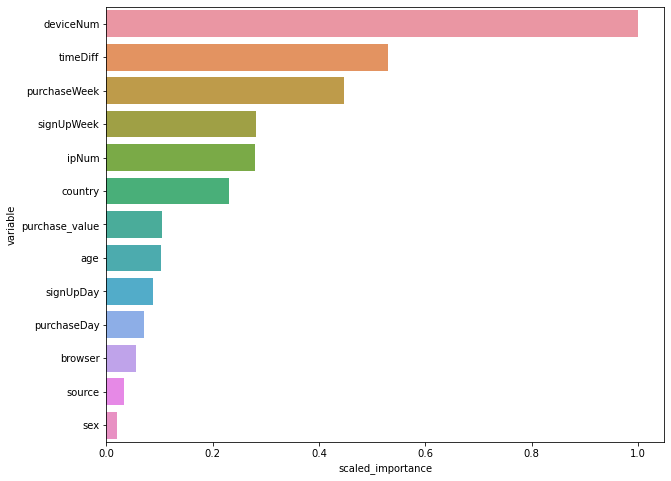

In [58]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()


In [66]:
from sklearn.metrics import roc_curve, auc

In [67]:
# Make predictions 
train_true = train.as_data_frame()['class'].values
test_true = test.as_data_frame()['class'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [68]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [69]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41088
           1       1.00      0.53      0.69      4245

    accuracy                           0.96     45333
   macro avg       0.98      0.76      0.83     45333
weighted avg       0.96      0.96      0.95     45333



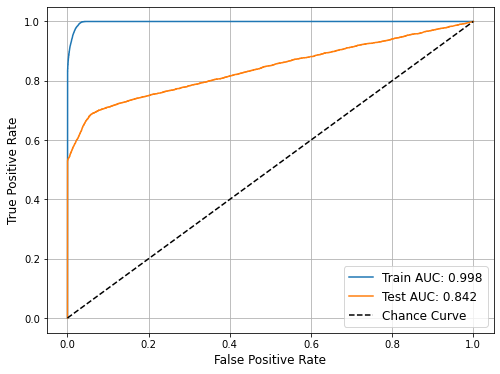

In [70]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero (this was essentially the random forest output). However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up).

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


/Users/qq/opt/anaconda3/lib/python3.8/site-packages/h2o/model/model_base.py:1372: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0
 17.0 18.0 19.0 20.0] in fill_betweenx(). This will become an error two minor releases later.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)
/Users/qq/opt/anaconda3/lib/python3.8/site-packages/h2o/model/model_base.py:1372: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [1.0 435.1608040201005 869.321608040201 1303.4824120603016
 1737.643216080402 2171.8040201005024 2605.964824120603 3040.1256281407036
 3474.286432160804 3908.4472361809044 4342.608040201005 4776.768844221106
 5210.929648241206 5645.090452261306 6079.251256281407 6513.412060301507
 6947.572864321608 7381.733668341709 7815.894472361809 8250.055276381909
 8684.21608040201 9118.37688442211 9552.537688442

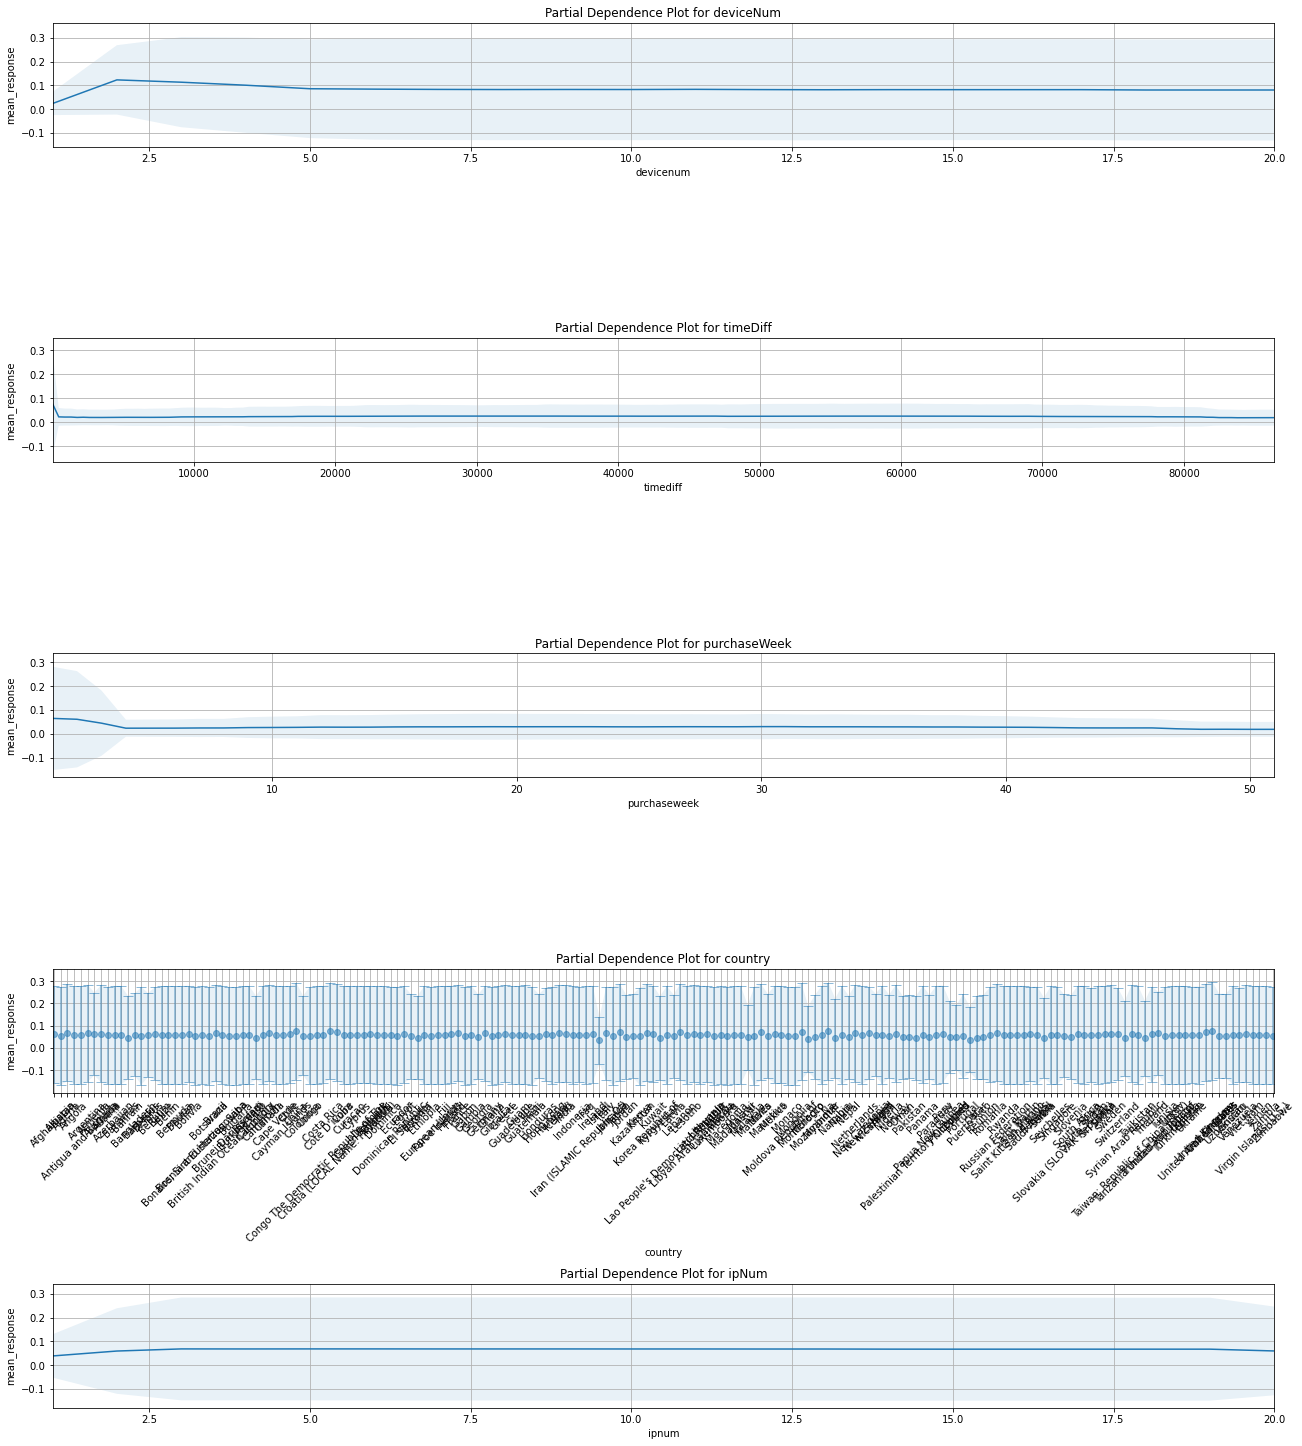

In [73]:
cols = ['deviceNum', 'timeDiff', 'purchaseWeek', 'country', 'ipNum']
_ = model.partial_plot(data=train, cols=cols, nbins=200, figsize=(18, 20))

In [ ]:
# Shutdown h2o instance
h2o.cluster().shutdown()


Regarding “how to use this from a product perspective”: you now have a model that assigns to each user a probability of committing a fraud. You want to think about creating different experiences based on that. For instance:
1. If predicted fraud probability < X, the user has the normal experience (the high majority should fall here)
2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed.
This is just an example and there are many different ways to build products around some fraud score. However, it is important because it highlights that a ML model is often really useful when it is combined with a product which is able to take advantage of its strengths and minimize its possible drawbacks (like false positives).